In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/NEERAJISM/Capstone/refs/heads/main/2021/Q1_2021_1_min_data.csv")


In [8]:
# Combine into one 'datetime' column
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.sort_values(['ticker', 'datetime'], inplace=True)

In [9]:
def detect_regimes(data):
    data = data.copy()
    data.set_index('datetime', inplace=True)

    # Log returns
    data['log_return'] = np.log(data['close'] / data['close'].shift(1))

    # Rolling volatility
    data['volatility'] = data['log_return'].rolling(window=15).std() * np.sqrt(15)

    # Rolling slope
    window = 15
    data['slope'] = data['close'].rolling(window).apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0]
    )

    # Drop NA
    data.dropna(inplace=True)

    # Features
    features = data[['log_return', 'volatility', 'slope']].values
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # HMM model
    hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000, random_state=42)
    hmm_model.fit(features_scaled)

    # Predict regimes
    data['regime'] = hmm_model.predict(features_scaled)

    # Label regimes
    regime_stats = data.groupby('regime')[['volatility', 'slope']].mean()
    trending_regime = regime_stats['slope'].abs().idxmax()
    sideways_regime = 1 - trending_regime

    data['regime_label'] = data['regime'].apply(
        lambda x: 'Trending' if x == trending_regime else 'Sideways'
    )

    # Store regime probabilities
    probs = hmm_model.predict_proba(features_scaled)
    data['prob_trending'] = probs[:, trending_regime]
    data['prob_sideways'] = probs[:, sideways_regime]

    return data

In [10]:
# Run regime detection for each ticker
results = []
for ticker, group in df.groupby('ticker'):
    res = detect_regimes(group)
    res['ticker'] = ticker
    results.append(res)

final_df = pd.concat(results)
final_df.reset_index(inplace=True)

In [14]:
summary = final_df.groupby('ticker')['regime_label'].value_counts(normalize=True).unstack().fillna(0) * 100
summary['Dominant Regime'] = summary.apply(lambda x: 'Trending' if x['Trending'] > x['Sideways'] else 'Sideways', axis=1)

print("\nMost Trending Stocks in Q1 2021:")
summary.sort_values('Trending', ascending=False).head(10)



Most Trending Stocks in Q1 2021:


regime_label,Sideways,Trending,Dominant Regime
ticker,,,
HINDUNILVR,65.753725,34.246275,Sideways
ADANIENT,68.702625,31.297375,Sideways
RELIANCE,73.652878,26.347122,Sideways
LT,75.242059,24.757941,Sideways
INFY,75.454267,24.545733,Sideways
TCS,76.739806,23.260194,Sideways
BAJFINANCE,77.842502,22.157498,Sideways
ICICIBANK,80.446683,19.553317,Sideways
HDFCBANK,81.677250,18.322750,Sideways


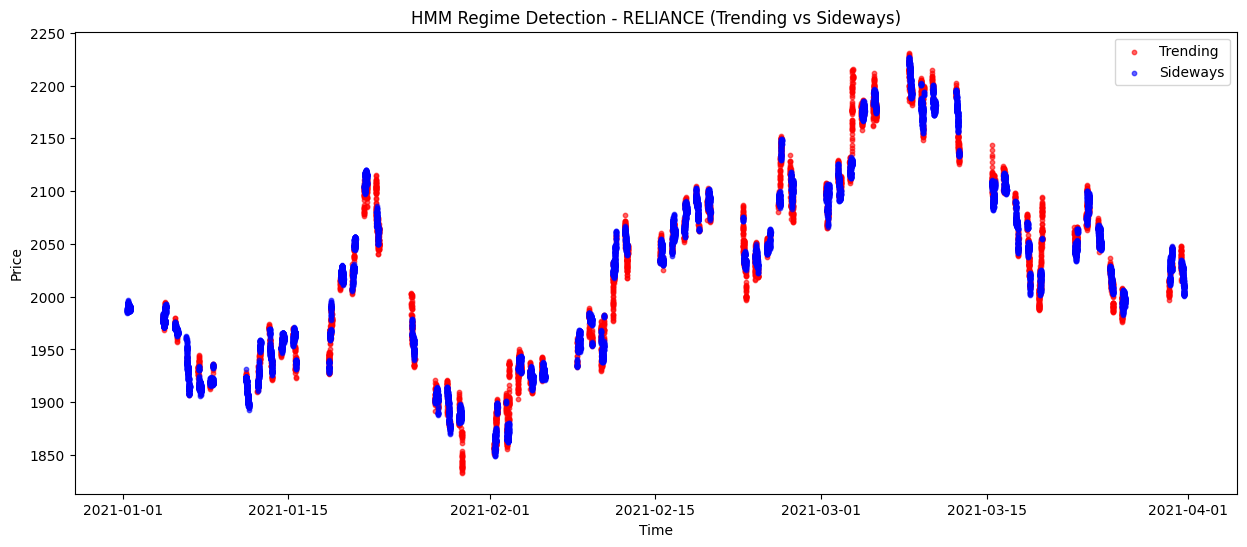

In [12]:
ticker_to_plot = "RELIANCE"  # Change to any ticker in your dataset
plot_df = final_df[final_df['ticker'] == ticker_to_plot]

plt.figure(figsize=(15,6))
for label, color in zip(['Trending', 'Sideways'], ['red', 'blue']):
    mask = plot_df['regime_label'] == label
    plt.scatter(plot_df['datetime'][mask], plot_df['close'][mask], label=label, alpha=0.6, s=10, color=color)

plt.title(f"HMM Regime Detection - {ticker_to_plot} (Trending vs Sideways)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [15]:
time_blocks = {
    'Morning': ('09:15:00', '10:30:00'),
    'Midday': ('10:30:01', '13:30:00'),
    'Afternoon': ('13:30:01', '15:30:00')
}

In [16]:
final_df['time'] = final_df['datetime'].dt.time

# Function to assign time block
def assign_time_block(t):
    t_str = t.strftime('%H:%M:%S')
    for block, (start, end) in time_blocks.items():
        if start <= t_str <= end:
            return block
    return None

In [17]:
final_df['time_block'] = final_df['time'].apply(assign_time_block)


In [18]:
trend_summary = (
    final_df.groupby(['ticker', 'time_block'])['regime_label']
    .apply(lambda x: (x == 'Trending').mean() * 100)
    .reset_index(name='%_trending')
)


In [19]:
heatmap_data = trend_summary.pivot(index='ticker', columns='time_block', values='%_trending')


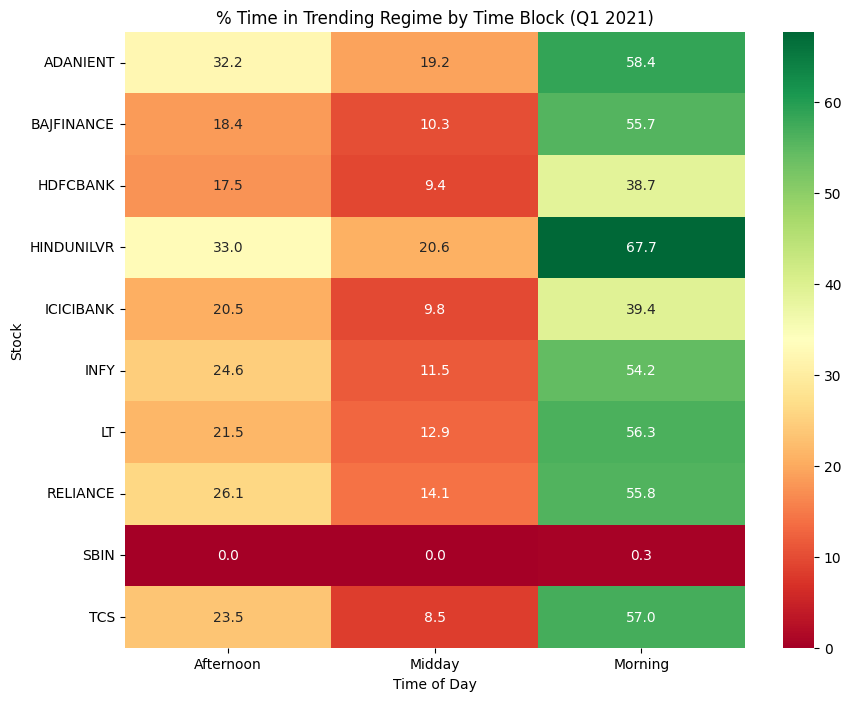

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="RdYlGn")
plt.title("% Time in Trending Regime by Time Block (Q1 2021)")
plt.ylabel("Stock")
plt.xlabel("Time of Day")
plt.show()